In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import keras_tuner as kt

from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout

from sklearn.model_selection import train_test_split

In [7]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.8)

X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

# EDA

In [23]:
import seaborn as sns
pd.value_counts(y_valid) / len(y_valid)

1    0.114667
7    0.103583
0    0.100833
3    0.100667
2    0.099333
9    0.098500
8    0.098250
4    0.098083
6    0.094917
5    0.091167
dtype: float64

No major class imbalance.

In [24]:
class_names = [str(x) for x in np.arange(1, 10, 1)]

In [ ]:
class_names[]

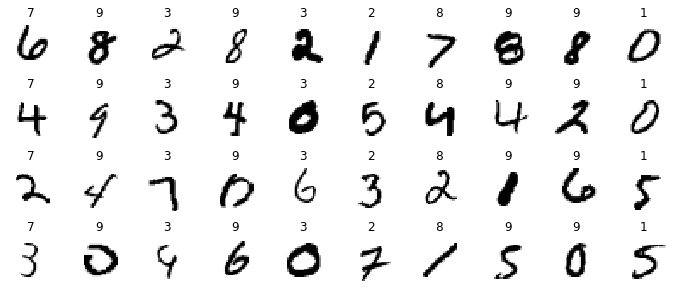

In [33]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index%10]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
# plt.save_fig('digits_mnist_plot', tight_layout=False)
plt.show()

# Original Model

In [38]:
log_dir = './tensorboard-logs/image-classifier-digits-dataset/original'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

In [39]:
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [41]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

In [42]:
# setup optimizer
optimizer = keras.optimizers.SGD()

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [43]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=30, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb],
)

Epoch 1/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.6194 - accuracy: 0.8443 - val_loss: 0.3148 - val_accuracy: 0.9128
Epoch 2/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2989 - accuracy: 0.9151 - val_loss: 0.2491 - val_accuracy: 0.9306
Epoch 3/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2470 - accuracy: 0.9302 - val_loss: 0.2146 - val_accuracy: 0.9392
Epoch 4/30
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2121 - accuracy: 0.9399 - val_loss: 0.1867 - val_accuracy: 0.9481
Epoch 5/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1862 - accuracy: 0.9470 - val_loss: 0.1700 - val_accuracy: 0.9522
Epoch 6/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1657 - accuracy: 0.9531 - val_loss: 0.1529 - val_accuracy: 0.9573
Epoch 7/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1494 - accuracy: 0.9578 - val_loss: 0.1395 - val_accuracy:

## Learning Rate Scheduler

In [45]:
log_dir = './tensorboard-logs/image-classifier-digits-dataset/lr'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

In [46]:
# setup LR scheduler
# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.1, 
    decay_steps = 5, 
    decay_rate = 0.5, 
    staircase=True # staircase function, 
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

In [48]:
log_dir = './tensorboard-logs/image-classifier-digits-dataset/lr'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.SGD()

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb, lr_scheduler],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/50
1500/1500 [==============================] - 10s 6ms/step - loss: 0.2884 - accuracy: 0.9142 - val_loss: 0.1321 - val_accuracy: 0.9592 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1163 - accuracy: 0.9654 - val_loss: 0.0922 - val_accuracy: 0.9722 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0787 - accuracy: 0.9752 - val_loss: 0.0883 - val_accuracy: 0.9742 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0563 - accuracy: 0.9826 - val_loss: 0.0762 - val_accuracy: 0.9776 - lr: 0.1000

Epoch 5: LearningRateScheduler setting learning rate to 0.

KeyboardInterrupt: 

# Regularization

In [50]:
log_dir = './tensorboard-logs/image-classifier-digits-dataset/dropout'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# setup LR scheduler
# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.1, 
    decay_steps = 10, 
    decay_rate = 0.5, 
    staircase=True # staircase function, 
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.SGD()

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb, lr_scheduler],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3299 - accuracy: 0.8994 - val_loss: 0.1480 - val_accuracy: 0.9565 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1540 - accuracy: 0.9545 - val_loss: 0.0995 - val_accuracy: 0.9708 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1158 - accuracy: 0.9649 - val_loss: 0.0836 - val_accuracy: 0.9758 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0901 - accuracy: 0.9729 - val_loss: 0.0819 - val_accuracy: 0.9760 - lr: 0.1000

Epoch 5: LearningRateScheduler setting learning rate to 0.1